# Project 1 - Aurèle Bohbot, Quentin Guilhot, Yanis Tournier

In [628]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import plotly.express as px
from numpy import where
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, LogisticRegression
from sklearn.metrics import r2_score
from collections import Counter
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel, f_regression, mutual_info_regression
from sklearn.tree import ExtraTreeRegressor
import math as m
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier, ExtraTreesRegressor, AdaBoostRegressor, VotingRegressor, HistGradientBoostingRegressor,StackingRegressor
from sklearn.feature_selection import RFE, RFECV, GenericUnivariateSelect
from sklearn.svm import SVR, LinearSVC, SVC, LinearSVR, OneClassSVM, NuSVR
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from xgboost import XGBRegressor
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer

In [629]:
X = pd.read_csv('X_train.csv').drop(columns=['id'])
Xt = pd.read_csv('X_test.csv')
y = pd.read_csv('y_train.csv')
to_drop = ['x104', 'x129', 'x489', 'x530']
X = X.drop(columns=to_drop)
y = y.drop(columns=['id'])

In [505]:
## Persentage of missing values
print(np.mean((X.notna().sum())/(X.sum())*100))

4.705194784035201


In [630]:
## Using KNN to fill missing values:
imputer = KNNImputer(n_neighbors=15)
X_filled = imputer.fit_transform(X)

In [ ]:
imp_mean = IterativeImputer(estimator=RandomForestRegressor(),missing_values=np.nan, sample_posterior=True, max_iter=10, tol=0.001, n_nearest_features=5, initial_strategy='mean', imputation_order='ascending', skip_complete=False, min_value=-np.inf, max_value=np.inf, verbose=1, random_state=None, add_indicator=False)
X_filled = imp_mean.fit_transform(X)## Using iterative Imputer to fill up the Nans


In [631]:
X_train_filled, X_test_filled, y_train, y_test = train_test_split(X_filled, y, test_size=0.2, random_state=42)

### Handling outliers

### Handling missing values 

For the moment, we replace the missing values by the column's median. Depending on the results, we might implement a knn algorithm.

In [632]:
scaler = StandardScaler()
scaler.fit(X_train_filled)
X_train_norm = scaler.transform(X_train_filled)
X_test_norm = scaler.transform(X_test_filled)

### Handling feature selections

In [633]:
## Univariate feature selection with the highest variance
select_feature = SelectKBest(f_regression, k=(100)).fit(X_train_norm, y_train)
X_train_new = select_feature.transform(X_train_norm)
X_test_new = select_feature.transform(X_test_norm)


/Users/yanistournier/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [641]:
sfs = SFS(estimator=SVR(),k_features='best',forward=True, floating=False,verbose=1,cv=5,n_jobs=-1)
sfs.fit(X_train_new, y_train.values.ravel())
X_train_new = sfs.transform(X_train_new)
X_test_new = sfs.transform(X_test_new)
sfs.k_feature_names_
print(X_train_new.shape)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/Users/yanistournier/opt/miniconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator SVR from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/yanistournier/opt/miniconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator SVR from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/yanistournier/opt/miniconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator SVR from versi

AttributeError: SequentialFeatureSelector has not been fitted, yet.

In [ ]:
## Feature selection/ranking with recursive feature elimination


clf_rf_4 = LinearRegression()
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5,scoring='r2')   #5-fold cross-validation
rfecv = rfecv.fit(X_train_norm, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train_norm.columns[rfecv.support_])

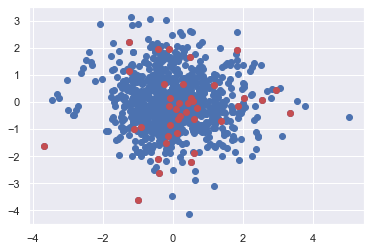

(39, 160) (969, 160)


(array([ 55,  56, 100, 101, 124, 142, 143, 152, 157, 168, 199, 223, 278,
        319, 332, 342, 395, 432, 472, 483, 509, 518, 521, 547, 558, 573,
        576, 582, 592, 596, 626, 631, 633, 639, 656, 688, 698, 846, 920]),)

In [413]:
## Outlier detection with multivariate technique: gaussian mixture model
elenv = EllipticEnvelope(contamination=0.04)

pred = elenv.fit_predict(X_train_new)
anom_index=where(pred==-1)
values_anom = X_train_new[anom_index]

plt.scatter(X_train_new[:,0], X_train_new[:,1])
plt.scatter(values_anom[:,0],values_anom[:,1], color='r')
plt.show()
print(values_anom.shape,X_train_new.shape)
anom_index

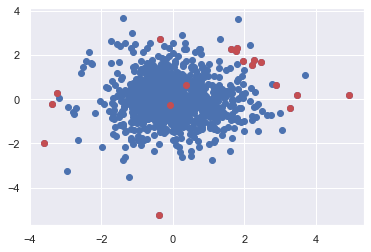

(18, 160) (969, 160)


(array([142, 184, 322, 359, 442, 483, 492, 518, 547, 558, 582, 620, 626,
        755, 819, 821, 836, 954]),)

In [570]:
## Outlier detection with multivariate technique: LOF
elenv = LocalOutlierFactor(n_neighbors=55)

pred = elenv.fit_predict(X_train_new)
anom_index=where(pred==-1)
values_anom = X_train_new[anom_index]

plt.scatter(X_train_new[:,0], X_train_new[:,1])
plt.scatter(values_anom[:,0],values_anom[:,1], color='r')
plt.show()
print(values_anom.shape,X_train_new.shape)
anom_index

In [571]:
## What do you with outliers
# 1/ just trying to drop them

X_train_less_outliers = np.delete(X_train_new,anom_index, axis=0)
Y_train_less_outliers = np.delete(y_train.values,anom_index, axis=0)
print(X_train_less_outliers.shape,Y_train_less_outliers.shape)

(951, 160) (951, 1)


In [572]:
model = LinearRegression()
model.fit(X_train_less_outliers, Y_train_less_outliers)
y_pred = model.predict(X_test_new)
y_pred.shape
score = r2_score(y_test, y_pred)
score

0.2629256491346308

In [573]:
model = NuSVR(nu=0.1, C=1000, kernel='rbf', degree=3, gamma='scale', coef0=0.1, shrinking=True, tol=0.001, cache_size=200, verbose=False, max_iter=-1)
model.fit(X_train_new, y_train)
y_pred = model.predict(X_test_new)
y_pred.shape
score = r2_score(y_test, y_pred)

score

/Users/yanistournier/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5195414636456503

In [575]:
model = XGBRegressor(n_estimators=1000, learning_rate=0.02, n_jobs=5)
model.fit(X_train_less_outliers, Y_train_less_outliers)
y_pred = model.predict(X_test_new)
y_pred.shape
score = r2_score(y_test, y_pred)
score

0.5861447664375823

In [574]:
model = SVR(kernel='rbf', gamma=0.01, tol=0.001, C=1000, epsilon=0.01, shrinking=True, cache_size=2000, verbose=False, max_iter=-1)
model.fit(X_train_less_outliers, Y_train_less_outliers)
y_pred = model.predict(X_test_new)
y_pred.shape
score = r2_score(y_test, y_pred)
score

/Users/yanistournier/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5477012316871895

In [552]:
model =GradientBoostingRegressor(loss='squared_error', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=5, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
model.fit(X_train_less_outliers, Y_train_less_outliers)
y_pred = model.predict(X_test_new)
y_pred.shape
score = r2_score(y_test, y_pred)
score

/Users/yanistournier/opt/miniconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5564503813621406

In [479]:
model = AdaBoostRegressor(n_estimators=200, learning_rate=3, loss='linear', random_state=None)
model.fit(X_train_less_outliers, Y_train_less_outliers)
y_pred = model.predict(X_test_new)
y_pred.shape
score = r2_score(y_test, y_pred)
score

/Users/yanistournier/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5107171947713656

In [537]:
## RFD with normalize data and without outliers

regr = RandomForestRegressor(n_estimators=1000, criterion='squared_error', max_depth=None, min_samples_split=4, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=1.0, max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)
regr.fit(X_train_less_outliers, Y_train_less_outliers)
y_pred = regr.predict(X_test_new)
score = r2_score(y_test, y_pred)
score


/var/folders/xz/2x_7tl010yn5bqd9lf1tsr3m0000gn/T/ipykernel_26403/2196559684.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X_train_less_outliers, Y_train_less_outliers)


0.5694521647222528

In [551]:
regr = HistGradientBoostingRegressor(loss='poisson', learning_rate=0.05, max_iter=1000, max_leaf_nodes=31, max_depth=None, min_samples_leaf=15, l2_regularization=0.1, max_bins=255, categorical_features=None, monotonic_cst=None, warm_start=False, early_stopping='auto', scoring='loss', validation_fraction=0.1, n_iter_no_change=10, tol=1e-07, verbose=0, random_state=None)
regr.fit(X_train_less_outliers, Y_train_less_outliers)
y_pred = regr.predict(X_test_new)
score = r2_score(y_test, y_pred)
score

/Users/yanistournier/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5870821084481458

In [ ]:
r1 = GradientBoostingRegressor(loss='squared_error', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=5, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
r2 = SVR(kernel='rbf', gamma=0.01, tol=0.001, C=1000, epsilon=0.01, shrinking=True, cache_size=2000, verbose=False, max_iter=-1)
r3 = RandomForestRegressor(max_depth=20, random_state=0)
r5 = HistGradientBoostingRegressor(loss='poisson', learning_rate=0.05, max_iter=100, max_leaf_nodes=31, max_depth=None, min_samples_leaf=20, l2_regularization=0.0, max_bins=255, categorical_features=None, monotonic_cst=None, warm_start=False, early_stopping='auto', scoring='loss', validation_fraction=0.1, n_iter_no_change=10, tol=1e-07, verbose=0, random_state=None)


estimators = [('lr',r1),('svr', r2)]
reg = StackingRegressor(estimators=estimators,final_estimator=r5)
regr.fit(X_train_less_outliers, Y_train_less_outliers)
y_pred = regr.predict(X_test_new)
score = r2_score(y_test, y_pred)
score

In [562]:
r1 = GradientBoostingRegressor(loss='squared_error', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=5, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
r2 = SVR(kernel='rbf', gamma=0.01, tol=0.001, C=1000, epsilon=0.01, shrinking=True, cache_size=2000, verbose=False, max_iter=-1)
r3 = NuSVR(nu=0.2, C=1000, kernel='rbf', degree=3, gamma='scale', coef0=0.1, shrinking=True, tol=0.001, cache_size=200, verbose=False, max_iter=-1)
r4 = XGBRegressor(n_estimators=1000, learning_rate=0.02, n_jobs=4)
r5 = HistGradientBoostingRegressor(loss='squared_error', learning_rate=0.05, max_iter=1000, max_leaf_nodes=31, max_depth=None, min_samples_leaf=15, l2_regularization=0.1, max_bins=255, categorical_features=None, monotonic_cst=None, warm_start=False, early_stopping='auto', scoring='loss', validation_fraction=0.1, n_iter_no_change=10, tol=1e-07, verbose=0, random_state=None)
regr = VotingRegressor([('lr', r1), ('rf', r2), ('r3', r3), ('abr', r4), ('HGB', r5)], weights=[1,3,1,2,1],n_jobs=None)
regr.fit(X_train_less_outliers, Y_train_less_outliers)
y_pred = regr.predict(X_test_new)
score = r2_score(y_test, y_pred)
score

/Users/yanistournier/opt/miniconda3/lib/python3.8/site-packages/sklearn/ensemble/_voting.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6149401782965425

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [207]:
## Final training for submit

X = pd.read_csv('X_train.csv')
Xt = pd.read_csv('X_test.csv')
y = pd.read_csv('y_train.csv')
to_drop = ['x104', 'x129', 'x489', 'x530', 'id']
X_train_final = X.drop(columns=to_drop)
X_test_final = Xt.drop(columns=to_drop)
y_train_final = y.drop(columns=['id']) 

In [208]:
y_train = y_train_final.fillna(y_train_final.median())
X_train_filled = X_train_final.fillna(X_train_final.median())
X_test_filled = X_test_final.fillna(X_test_final.median())

scaler = StandardScaler()
scaler.fit(X_train_filled)
X_train_norm = scaler.transform(X_train_filled)
X_test_norm = scaler.transform(X_test_filled)
print(X_train_norm.shape,X_test_norm.shape)

(1212, 828) (776, 828)


In [209]:
select_feature = SelectKBest(f_regression, k=(160)).fit(X_train_norm, y_train)
X_train_new = select_feature.transform(X_train_norm)
X_test_new = select_feature.transform(X_test_norm)
print(X_train_new.shape,X_test_new.shape)

(1212, 160) (776, 160)


/Users/yanistournier/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


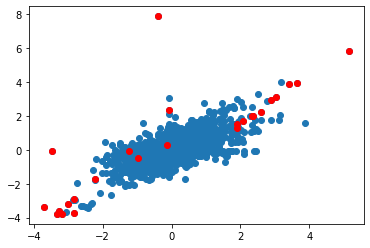

(25, 160) (1212, 160)
(1187, 160) (1187, 1)


In [210]:
## Outlier detection with multivariate technique: gaussian mixture model
elenv = EllipticEnvelope(contamination=0.02)

pred = elenv.fit_predict(X_train_new)
anom_index=where(pred==-1)
values_anom = X_train_new[anom_index]

plt.scatter(X_train_new[:,0], X_train_new[:,1])
plt.scatter(values_anom[:,0],values_anom[:,1], color='r')
plt.show()
print(values_anom.shape,X_train_new.shape)
X_train_less_outliers = np.delete(X_train_new,anom_index, axis=0)
Y_train_less_outliers = np.delete(y_train.values,anom_index, axis=0)
print(X_train_less_outliers.shape,Y_train_less_outliers.shape)

In [211]:
r1 = GradientBoostingRegressor(loss='squared_error', learning_rate=0.1, n_estimators=1000, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=5, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
r2 = SVR(kernel='rbf', gamma=0.01, tol=0.001, C=1000, epsilon=0.01, shrinking=True, cache_size=2000, verbose=False, max_iter=-1)

regr = VotingRegressor([('lr', r1), ('rf', r2)], weights=[2,3],n_jobs=None)
regr.fit(X_train_less_outliers, Y_train_less_outliers)
y_pred = regr.predict(X_test_new)


/Users/yanistournier/opt/miniconda3/lib/python3.8/site-packages/sklearn/ensemble/_voting.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [116]:
model = SVR(kernel='rbf', gamma=0.01, tol=0.001, C=100, epsilon=0.1, shrinking=True, cache_size=2000, verbose=False, max_iter=-1)
model.fit(X_train_less_outliers, Y_train_less_outliers)
y_pred = model.predict(X_test_new)

/Users/yanistournier/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [212]:
y_pred.shape

(776,)

In [213]:
pd.DataFrame({'id': [float(i) for i in range(y_pred.size)], 'y': y_pred}).to_csv('Prediction.csv')